In [18]:
# Initial imports
from path import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import psycopg2 as pg

In [19]:
engine = pg.connect("dbname='postgres' user='postgres' host='database-final.cjdbapst3wjf.us-east-1.rds.amazonaws.com' port='5432' password='FinalProject05'")
Contributions = pd.read_sql('select * from merged_2017', con=engine)
Contributions.head()
Contributions.dropna()

,election,candidateid,candidatename,date,contributiontype,city,state,zipcode,amount,matchamt,prevamt,totalamount,expenditure_amount,purposecode,purpose
0,2017,326,"Bill,de Blasio",2017-08-14,Corporation,Brooklyn,NY,11201,0.0,0,0.0,0.0,518,Office Expenses,Office Expenses
1,2017,326,"Bill,de Blasio",2017-09-21,Corporation,Brooklyn,NY,11201,0.0,0,0.0,0.0,1041,Office Expenses,Office Expenses
2,2017,326,"Bill,de Blasio",2017-12-29,Corporation,Brooklyn,NY,11201,0.0,0,0.0,0.0,1500,Office Rent,Office Rent
3,2017,2055,"Roque,De La Fuente",2017-07-14,Corporation,New York,NY,10025,0.0,0,0.0,0.0,6000,Professional Services,Prof. Srvcs.
4,2017,2055,"Roque,De La Fuente",2017-06-09,Corporation,New York,NY,10025,0.0,0,0.0,0.0,6000,Professional Services,Prof. Srvcs.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,2017,2071,"Nicole,Malliotakis",2017-11-04,Individual,Astoria,NY,11102,0.0,0,0.0,0.0,54,Advance Repayment,Advance Repaymnt
3790,2017,2071,"Nicole,Malliotakis",2017-11-08,Individual,Astoria,NY,11102,0.0,0,0.0,0.0,125,Fundraising,Fundraising
3791,2017,326,"Bill,de Blasio",2016-09-08,Individual,New York,NY,10021,0.0,0,0.0,0.0,239,Other,Other: explntion
3792,2017,326,"Bill,de Blasio",2016-12-27,Individual,New York,NY,10021,0.0,0,0.0,0.0,239,Other,Other: explntion


In [20]:
Contributions_df = Contributions.drop(columns=['election','prevamt'])
total_groupby = Contributions_df.groupby(['candidatename']).sum(['totalamount']).sort_values('totalamount',ascending=False)
Contributions_df['zipcode'] = Contributions_df['zipcode'].apply(str)

In [21]:
Contributions_df = Contributions_df.groupby(['zipcode','date','contributiontype','city','state']).sum('totalamount')

In [22]:
Contributions_df.head()

amount  matchamt  \
zipcode date       contributiontype city     state                        
0       2016-11-15  Marcia          Q        Rosedale     0.0       100   
        2016-12-16 Individual       Weston   CT         175.0         0   
        2017-01-07 Individual       NYC      NY          10.0         0   
        2017-01-11 Individual       BRONX    NY          10.0        10   
                                    New York NY          10.0        10   

                                                       totalamount  \
zipcode date       contributiontype city     state                   
0       2016-11-15  Marcia          Q        Rosedale          0.0   
        2016-12-16 Individual       Weston   CT              175.0   
        2017-01-07 Individual       NYC      NY               10.0   
        2017-01-11 Individual       BRONX    NY               20.0   
                                    New York NY               20.0   

                                                       expenditure_amount  
zipcode date       contributiontype city     state                         
0       2016-11-15  Marcia          Q        Rosedale                   0  
        2016-12-16 Individual       Weston   CT                         0  
        2017-01-07 Individual       NYC      NY                         0  
        2017-01-11 Individual       BRONX    NY                         0  
                                    New York NY                         0

In [23]:
Contributions_df = Contributions_df.reset_index()
Contributions_df['contributiontype'].unique()

array([' Marcia', 'Individual', 'Corporation',
       'Political Action Committee', 'Labor Union', 'Candidate Committee',
       'Other', 'Limited Liability Company', 'Party Committee',
       'Candidate', 'Candidate Family'], dtype=object)

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Contributions_df_enc = Contributions_df.copy()
le = LabelEncoder()
Contributions_df_enc['date'] = le.fit_transform(Contributions_df['date'])
Contributions_df_enc['contributiontype'] = le.fit_transform(Contributions_df['contributiontype'])
Contributions_df_enc['city'] = le.fit_transform(Contributions_df['city'])
Contributions_df_enc['state'] = le.fit_transform(Contributions_df['state'])
Contributions_df_enc['zipcode'] = le.fit_transform(Contributions_df['zipcode'])
features = list(Contributions_df_enc.columns)
Contributions_df_enc[features] = scaler.fit_transform(Contributions_df_enc[features])
Contributions_df_enc.head()

,zipcode,date,contributiontype,city,state,amount,matchamt,totalamount,expenditure_amount
0,0.0,0.499383,0.0,0.683142,0.788462,0.019108,0.024661,0.018357,0.0
1,0.0,0.537608,0.5,0.927556,0.134615,0.025934,0.000000,0.024914,0.0
2,0.0,0.564735,0.5,0.536899,0.653846,0.019498,0.000000,0.018731,0.0
3,0.0,0.569667,0.5,0.051456,0.653846,0.019498,0.002466,0.019106,0.0
4,0.0,0.569667,0.5,0.560596,0.653846,0.019498,0.002466,0.019106,0.0


In [25]:
X = Contributions_df_enc.drop('totalamount',axis = 1)
y = Contributions_df_enc['totalamount']
Contributions_df_enc.nunique()

zipcode               1616
date                   812
contributiontype        11
city                  1478
state                   53
amount                 725
matchamt               346
totalamount           1188
expenditure_amount     888
dtype: int64

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=79)

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [28]:
regr = RandomForestRegressor()

In [29]:
regr.fit(X_train, y_train)

RandomForestRegressor()

In [30]:
y_pred = regr.predict(X_test)
print(len(y_pred))

5608


In [31]:
from sklearn.metrics import r2_score
r_squared = r2_score(y_test, y_pred)

0.9146399476888686


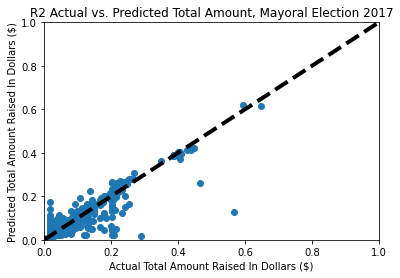

In [32]:
print(r_squared)
plt.scatter(y_test,y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual Total Amount Raised In Dollars ($)')
plt.ylabel('Predicted Total Amount Raised In Dollars ($)')
plt.title('R2 Actual vs. Predicted Total Amount, Mayoral Election 2017')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.savefig('../Resources/Predicted_Total_Amount_Regression_2017.png')

In [33]:
pred_df = X_test
pred_df['Total Amount'] = y_test
pred_df['Predicted Total Amount'] = y_pred
pred_df.head()

/Users/Abir/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Abir/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,zipcode,date,contributiontype,city,state,amount,matchamt,expenditure_amount,Total Amount,Predicted Total Amount
9082,0.147988,0.564735,0.5,0.087339,0.653846,0.019498,0.002466,0.000000,0.019106,0.019168
13062,0.178328,0.921085,0.5,0.932972,0.653846,0.038609,0.043157,0.000000,0.043647,0.046556
16192,0.391950,0.939581,0.4,0.897089,0.173077,0.019108,0.000000,0.000427,0.018357,0.018357
17470,0.723220,0.060419,0.4,0.574814,0.596154,0.019108,0.000000,0.000052,0.018357,0.018357
7777,0.073065,0.315660,0.5,0.104265,0.653846,0.029834,0.000000,0.000000,0.028660,0.042169


In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

0.013216529955409707